<img src='images/netflix-q.jpg'>

In [1]:
# this is just to know how much time will it take to run this entire ipython notebook 
from datetime import datetime
# globalstart = datetime.now()
import pandas as pd
import numpy as np
import matplotlib


import matplotlib.pyplot as plt


import seaborn as sns
sns.set_style('whitegrid')
import os
from scipy import sparse
from scipy.sparse import csr_matrix

from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import random

<h1>  __Exploratory Data Analysis__ </h1>

In [3]:
start = datetime.now()
if not os.path.isfile('data_submit.csv'):
    # Create a file 'data.csv' before reading it
    # Read all the files in netflix and store them in one big file('data.csv')
    # We re reading from each of the four files and appendig each rating to a global file 'train.csv'
    data = open('data_submit.csv', mode='w')
    
    row = list()
    files=['data_folder/combined_data_1.txt','data_folder/combined_data_2.txt', 
           'data_folder/combined_data_3.txt', 'data_folder/combined_data_4.txt']
    for file in files:
        print("Reading ratings from {}...".format(file))
        with open(file) as f:
            for line in f: 
                del row[:] # you don't have to do this.
                line = line.strip()
                if line.endswith(':'):
                    # All below are ratings for this movie, until another movie appears.
                    movie_id = line.replace(':', '')
                else:
                    row = [x for x in line.split(',')]
                    row.insert(0, movie_id)
                    data.write(','.join(row))
                    data.write('\n')
        print("Done.\n")
    data.close()
print('Time taken :', datetime.now() - start)

Reading ratings from data_folder/combined_data_1.txt...
Done.

Reading ratings from data_folder/combined_data_2.txt...
Done.

Reading ratings from data_folder/combined_data_3.txt...
Done.

Reading ratings from data_folder/combined_data_4.txt...
Done.

Time taken : 0:05:09.505527


In [2]:
print("creating the data_submitframe from data_submit.csv file..")
df = pd.read_csv('data_submit.csv', sep=',', 
                       names=['movie', 'user','rating','date'])
df.date = pd.to_datetime(df.date)
print('Done.\n')

# we are arranging the ratings according to time.
print('Sorting the data_submitframe by date..')
df.sort_values(by='date', inplace=True)
print('Done..')

creating the data_submitframe from data_submit.csv file..
Done.

Sorting the data_submitframe by date..
Done..


In [3]:
df.head()

,movie,user,rating,date
56431994,10341,510180,4,1999-11-11
9056171,1798,510180,5,1999-11-11
58698779,10774,510180,3,1999-11-11
48101611,8651,510180,2,1999-11-11
81893208,14660,510180,2,1999-11-11


In [4]:
df.describe()['rating']

count    1.004805e+08
mean     3.604290e+00
std      1.085219e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

In [5]:
df.describe()['user']

count    1.004805e+08
mean     1.322489e+06
std      7.645368e+05
min      6.000000e+00
25%      6.611980e+05
50%      1.319012e+06
75%      1.984455e+06
max      2.649429e+06
Name: user, dtype: float64

In [6]:
df.describe()['movie']

count    1.004805e+08
mean     9.070915e+03
std      5.131891e+03
min      1.000000e+00
25%      4.677000e+03
50%      9.051000e+03
75%      1.363500e+04
max      1.777000e+04
Name: movie, dtype: float64

<h1> Checking for NaN Values</h1>

In [7]:
# just to make sure that all Nan containing rows are deleted..
print("No of Nan values in our dataframe : ", sum(df.isnull().any()))

No of Nan values in our dataframe :  0


<h1> Removing Duplicates </h1>

In [8]:
dup_bool = df.duplicated(['movie','user','rating'])
dups = sum(dup_bool) # by considering all columns..( including timestamp)
print("There are {} duplicate rating entries in the data..".format(dups))

There are 0 duplicate rating entries in the data..


<h3>Basic Statistics (#Ratings, #Users, and #Movies) </h3>

In [11]:
print("Total data ")
print("-"*50)
print("\nTotal no of ratings :",df.shape[0])
print("Total No of Users   :", len(np.unique(df.user)))
print("Total No of movies  :", len(np.unique(df.movie)))

Total data 
--------------------------------------------------

Total no of ratings : 100480507
Total No of Users   : 480189
Total No of movies  : 17770


__Train & Test__

In [12]:
if not os.path.isfile('train_submit.csv'):
    # create the dataframe and store it in the disk for offline purposes..
    df.iloc[:int(df.shape[0]*0.80)].to_csv("train_submit.csv", index=False)

if not os.path.isfile('test_submit.csv'):
    # create the dataframe and store it in the disk for offline purposes..
    df.iloc[int(df.shape[0]*0.80):].to_csv("test_submit.csv", index=False)

train_submit_df = pd.read_csv("train_submit.csv", parse_dates=['date'])
test_submit_df = pd.read_csv("test_submit.csv")

In [13]:
# movies = train_submit_df.movie.value_counts()
# users = train_submit_df.user.value_counts()
print("Training data ")
print("-"*50)
print("\nTotal no of ratings :",train_submit_df.shape[0])
print("Total No of Users   :", len(np.unique(train_submit_df.user)))
print("Total No of movies  :", len(np.unique(train_submit_df.movie)))


print("="*123)
print("="*123)
print("\nTest data ")
print("-"*50)
print("\nTotal no of ratings :",test_submit_df.shape[0])
print("Total No of Users   :", len(np.unique(test_submit_df.user)))
print("Total No of movies  :", len(np.unique(test_submit_df.movie)))


Training data 
--------------------------------------------------

Total no of ratings : 80384405
Total No of Users   : 405041
Total No of movies  : 17424

Test data 
--------------------------------------------------

Total no of ratings : 20096102
Total No of Users   : 349312
Total No of movies  : 17757


In [14]:
# method to make y-axis more readable
def human(num, units = 'M'):
    units = units.lower()
    num = float(num)
    if units == 'k':
        return str(num/10**3) + " K"
    elif units == 'm':
        return str(num/10**6) + " M"
    elif units == 'b':
        return str(num/10**9) +  " B"

Here we put 1000 as "K", 1000000 as "M" and 1000000000 as "B".

__Distribution Of Ratings__

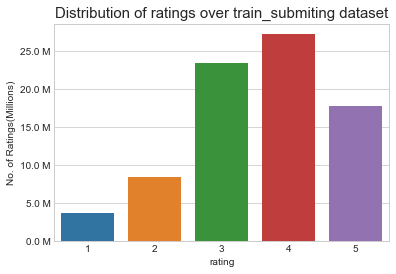

In [15]:
fig, ax = plt.subplots()
plt.title('Distribution of ratings over train_submiting dataset', fontsize=15)
sns.countplot(train_submit_df.rating)
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
ax.set_ylabel('No. of Ratings(Millions)')

plt.show()

<p style="font-size:13px"> <b>Add new column (week day) to the data set  for analysis.</b></p>

In [16]:
# It is used to skip the warning ''SettingWithCopyWarning''.. 
pd.options.mode.chained_assignment = None  # default='warn'

train_submit_df['day_of_week'] = train_submit_df.date.dt.weekday_name

train_submit_df.tail()

,movie,user,rating,date,day_of_week
80384400,12074,2033618,4,2005-08-08,Monday
80384401,862,1797061,3,2005-08-08,Monday
80384402,10986,1498715,5,2005-08-08,Monday
80384403,14861,500016,4,2005-08-08,Monday
80384404,5926,1044015,5,2005-08-08,Monday


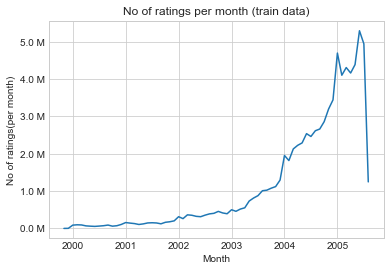

In [17]:
ax = train_submit_df.resample('m', on='date')['rating'].count().plot()
ax.set_title('No of ratings per month (train data)')
plt.xlabel('Month')
plt.ylabel('No of ratings(per month)')
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
plt.show()

<h3> Analysis on the Ratings given by user </h3>

In [18]:
no_of_rated_movies_per_user = train_submit_df.groupby(by='user')['rating'].count().sort_values(ascending=False)

no_of_rated_movies_per_user.head()

user
305344     17112
2439493    15896
387418     15402
1639792     9767
1461435     9447
Name: rating, dtype: int64

C:\Users\ankan\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


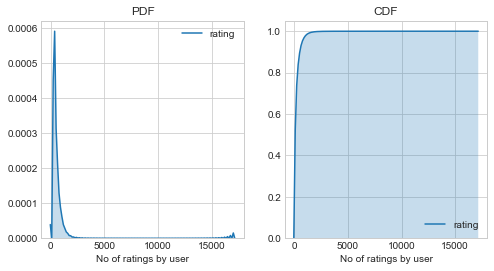

In [19]:
fig = plt.figure(figsize=plt.figaspect(.5))

ax1 = plt.subplot(121)
sns.kdeplot(no_of_rated_movies_per_user, shade=True, ax=ax1)
plt.xlabel('No of ratings by user')
plt.title("PDF")

ax2 = plt.subplot(122)
sns.kdeplot(no_of_rated_movies_per_user, shade=True, cumulative=True,ax=ax2)
plt.xlabel('No of ratings by user')
plt.title('CDF')

plt.show()

In [20]:
no_of_rated_movies_per_user.describe()

count    405041.000000
mean        198.459921
std         290.793238
min           1.000000
25%          34.000000
50%          89.000000
75%         245.000000
max       17112.000000
Name: rating, dtype: float64

> _There,  is something interesting going on with the quantiles.._

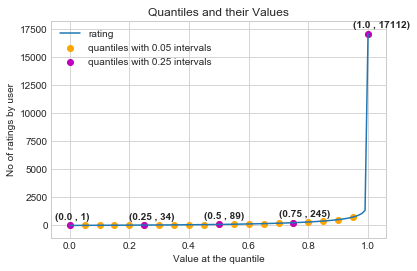

0.00        1
0.05        7
0.10       15
0.15       21
0.20       27
0.25       34
0.30       41
0.35       50
0.40       60
0.45       73
0.50       89
0.55      109
0.60      133
0.65      163
0.70      199
0.75      245
0.80      307
0.85      392
0.90      520
0.95      749
1.00    17112
Name: rating, dtype: int64

 No of ratings at last 5 percentile : 20305



In [21]:
quantiles = no_of_rated_movies_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')

plt.title("Quantiles and their Values")
quantiles.plot()
# quantiles with 0.05 difference
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label = "quantiles with 0.25 intervals")
plt.ylabel('No of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')

# annotate the 25th, 50th, 75th and 100th percentile values....
for x,y in zip(quantiles.index[::25], quantiles[::25]):
    plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500)
                ,fontweight='bold')


plt.show()

print(quantiles[::5])

print('\n No of ratings at last 5 percentile : {}\n'.format(sum(no_of_rated_movies_per_user>= 749)) )

<h3>  Analysis of ratings of a movie given by a user </h3>

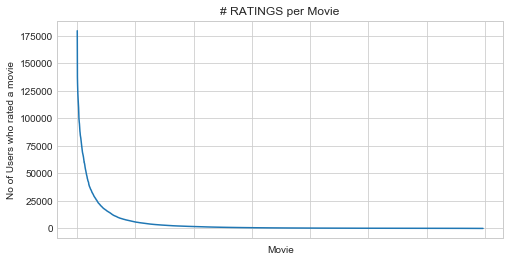

In [22]:
no_of_ratings_per_movie = train_submit_df.groupby(by='movie')['rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_movie.values)
plt.title('# RATINGS per Movie')
plt.xlabel('Movie')
plt.ylabel('No of Users who rated a movie')
ax.set_xticklabels([])

plt.show()

- __It is very skewed.. just like nunmber of ratings given per user.__
    
    
    - There are some movies (which are very popular) which are rated by huge number of users.
    
    - But most of the movies(like 90%) got some hundereds of ratings.

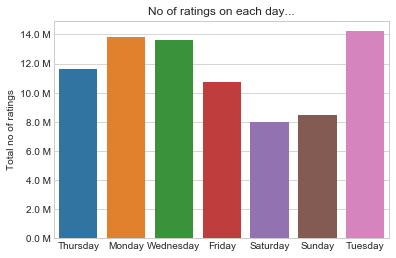

In [23]:
fig, ax = plt.subplots()
sns.countplot(x='day_of_week', data=train_submit_df, ax=ax)
plt.title('No of ratings on each day...')
plt.ylabel('Total no of ratings')
plt.xlabel('')
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
plt.show()

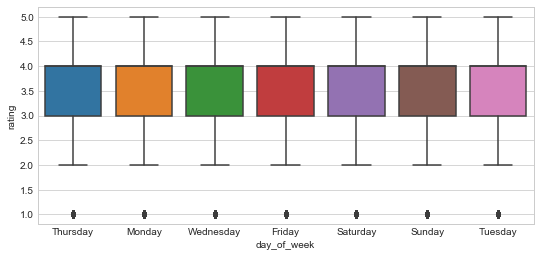

0:03:46.507235


In [24]:
start = datetime.now()
fig = plt.figure(figsize=plt.figaspect(.45))
sns.boxplot(y='rating', x='day_of_week', data=train_submit_df)
plt.show()
print(datetime.now() - start)

In [25]:
avg_week_df = train_submit_df.groupby(by=['day_of_week'])['rating'].mean()
print(" AVerage ratings")
print("-"*30)
print(avg_week_df)
print("\n")

 AVerage ratings
------------------------------
day_of_week
Friday       3.585274
Monday       3.577250
Saturday     3.591791
Sunday       3.594144
Thursday     3.582463
Tuesday      3.574438
Wednesday    3.583751
Name: rating, dtype: float64




<h3>  Creating sparse matrix from data frame </h3>

<table>
<tr>
<td>
<img src='images/data_c.jpg' width='250px' align=left/>
</td>
<td>
<img src='images/arrow.jpg' width='60px' align=left/>
</td>
<td>
<img src='images/data_sparse_c.jpg' width='400px' align=left/>
</td>
</tr>
</table>

In [26]:
start = datetime.now()
if os.path.isfile('train_sparse_submit_matrix.npz'):
    print("It is present in your pwd, getting it from disk....")
    # just get it from the disk instead of computing it
    train_sparse_submit_matrix = sparse.load_npz('train_sparse_submit_matrix.npz')
    print("DONE..")
else: 
    print("We are creating sparse_matrix from the dataframe..")
    # create sparse_matrix and store it for after usage.
    # csr_matrix(data_values, (row_index, col_index), shape_of_matrix)
    # It should be in such a way that, MATRIX[row, col] = data
    train_sparse_submit_matrix = sparse.csr_matrix((train_submit_df.rating.values, (train_submit_df.user.values,
                                               train_submit_df.movie.values)),)
    
    print('Done. It\'s shape is : (user, movie) : ',train_sparse_submit_matrix.shape)
    print('Saving it into disk for furthur usage..')
    # save it into disk
    sparse.save_npz("train_sparse_submit_matrix.npz", train_sparse_submit_matrix)
    print('Done..\n')

print(datetime.now() - start)

It is present in your pwd, getting it from disk....
DONE..
0:01:10.035854


In [27]:
us,mv = train_sparse_submit_matrix.shape
elem = train_sparse_submit_matrix.count_nonzero()

print("Sparsity Of Train matrix : {} % ".format(  (1-(elem/(us*mv))) * 100) )

Sparsity Of Train matrix : 99.8292709259195 % 


In [28]:
start = datetime.now()
if os.path.isfile('test_sparse_submit_matrix.npz'):
    print("It is present in your pwd, getting it from disk....")
    # just get it from the disk instead of computing it
    test_sparse_submit_matrix = sparse.load_npz('test_sparse_submit_matrix.npz')
    print("DONE..")
else: 
    print("We are creating sparse_submit_matrix from the dataframe..")
    # create sparse_submit_matrix and store it for after usage.
    # csr_matrix(data_values, (row_index, col_index), shape_of_matrix)
    # It should be in such a way that, MATRIX[row, col] = data
    test_sparse_submit_matrix = sparse.csr_matrix((test_submit_df.rating.values, (test_submit_df.user.values,
                                               test_submit_df.movie.values)))
    
    print('Done. It\'s shape is : (user, movie) : ',test_sparse_submit_matrix.shape)
    print('Saving it into disk for furthur usage..')
    # save it into disk
    sparse.save_npz("test_sparse_submit_matrix.npz", test_sparse_submit_matrix)
    print('Done..\n')
    
print(datetime.now() - start)

It is present in your pwd, getting it from disk....
DONE..
0:00:21.612994


In [29]:
us,mv = test_sparse_submit_matrix.shape
elem = test_sparse_submit_matrix.count_nonzero()

print("Sparsity Of Test matrix : {} % ".format(  (1-(elem/(us*mv))) * 100) )

Sparsity Of Test matrix : 99.95731772988694 % 


<h3> Finding Global average of all movie ratings, Average rating per user, and Average rating per movie</h3>

In [30]:
# get the user averages in dictionary (key: user_id/movie_id, value: avg rating)

def get_average_ratings(sparse_matrix, of_users):
    
    # average ratings of user/axes
    ax = 1 if of_users else 0 # 1 - User axes,0 - Movie axes

    # ".A1" is for converting Column_Matrix to 1-D numpy array 
    sum_of_ratings = sparse_matrix.sum(axis=ax).A1
    # Boolean matrix of ratings ( whether a user rated that movie or not)
    is_rated = sparse_matrix!=0
    # no of ratings that each user OR movie..
    no_of_ratings = is_rated.sum(axis=ax).A1
    
    # max_user  and max_movie ids in sparse matrix 
    u,m = sparse_matrix.shape
    # creae a dictonary of users and their average ratigns..
    average_ratings = { i : sum_of_ratings[i]/no_of_ratings[i]
                                 for i in range(u if of_users else m) 
                                    if no_of_ratings[i] !=0}

    # return that dictionary of average ratings
    return average_ratings

In [31]:
train_averages = dict()
# get the global average of ratings in our train set.
train_global_average = train_sparse_submit_matrix.sum()/train_sparse_submit_matrix.count_nonzero()
train_averages['global'] = train_global_average
train_averages

{'global': 3.582890686321557}

In [32]:
train_averages['user'] = get_average_ratings(train_sparse_submit_matrix, of_users=True)
print('\nAverage rating of user 10 :',train_averages['user'][10])




Average rating of user 10 : 3.3781094527363185


In [33]:
train_averages['movie'] =  get_average_ratings(train_sparse_submit_matrix, of_users=False)
print('\n AVerage rating of movie 15 :',train_averages['movie'][15])
print('\n AVerage rating of movie 125 :',train_averages['movie'][125])
print('\n AVerage rating of movie 225 :',train_averages['movie'][225])
print('\n AVerage rating of movie 325 :',train_averages['movie'][325])


 AVerage rating of movie 15 : 3.3038461538461537

 AVerage rating of movie 125 : 3.3718944099378882

 AVerage rating of movie 225 : 2.729117298578199

 AVerage rating of movie 325 : 4.328431372549019


<h4>  PDF's & CDF's of Avg.Ratings of Users & Movies (In Train Data)</h4>

C:\Users\ankan\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


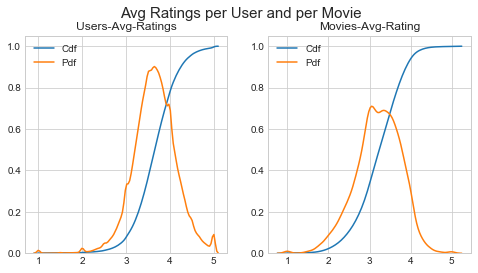

0:01:16.094002


In [34]:
start = datetime.now()
# draw pdfs for average rating per user and average
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(.5))
fig.suptitle('Avg Ratings per User and per Movie', fontsize=15)

ax1.set_title('Users-Avg-Ratings')
# get the list of average user ratings from the averages dictionary..
user_averages = [rat for rat in train_averages['user'].values()]
sns.distplot(user_averages, ax=ax1, hist=False, 
             kde_kws=dict(cumulative=True), label='Cdf')
sns.distplot(user_averages, ax=ax1, hist=False,label='Pdf')

ax2.set_title('Movies-Avg-Rating')
# get the list of movie_average_ratings from the dictionary..
movie_averages = [rat for rat in train_averages['movie'].values()]
sns.distplot(movie_averages, ax=ax2, hist=False, 
             kde_kws=dict(cumulative=True), label='Cdf')
sns.distplot(movie_averages, ax=ax2, hist=False, label='Pdf')

plt.show()
print(datetime.now() - start)

<h4> Cold Start problem with Users</h4>

In [35]:
total_users = len(np.unique(df.user))
users_train = len(train_averages['user'])
new_users = total_users - users_train

print('\nTotal number of Users  :', total_users)
print('\nNumber of Users in Train data :', users_train)
print("\nNo of Users that didn't appear in train data: {}({} %) \n ".format(new_users,
                                                                        np.round((new_users/total_users)*100, 2)))


Total number of Users  : 480189

Number of Users in Train data : 405041

No of Users that didn't appear in train data: 75148(15.65 %) 
 


> We might have to handle __new users__ ( ___75148___ ) who didn't appear in train data.

<h4>  Cold Start problem with Movies</h4>

In [36]:
total_movies = len(np.unique(df.movie))
movies_train = len(train_averages['movie'])
new_movies = total_movies - movies_train

print('\nTotal number of Movies  :', total_movies)
print('\nNumber of Users in Train data :', movies_train)
print("\nNo of Movies that didn't appear in train data: {}({} %) \n ".format(new_movies,
                                                                        np.round((new_movies/total_movies)*100, 2)))


Total number of Movies  : 17770

Number of Users in Train data : 17424

No of Movies that didn't appear in train data: 346(1.95 %) 
 


> We might have to handle __346 movies__ (small comparatively) in test data

<h2>  Computing Similarity matrices </h2>

In [37]:
from sklearn.metrics.pairwise import cosine_similarity


def compute_user_similarity(sparse_matrix, compute_for_few=False, top = 100, verbose=False, verb_for_n_rows = 20,
                            draw_time_taken=True):
    no_of_users, _ = sparse_matrix.shape
    # get the indices of  non zero rows(users) from our sparse matrix
    row_ind, col_ind = sparse_matrix.nonzero()
    row_ind = sorted(set(row_ind)) # we don't have to
    time_taken = list() #  time taken for finding similar users for an user..
    
    # we create rows, cols, and data lists.., which can be used to create sparse matrices
    rows, cols, data = list(), list(), list()
    if verbose: print("Computing top",top,"similarities for each user..")
    
    start = datetime.now()
    temp = 0
    
    for row in row_ind[:top] if compute_for_few else row_ind:
        temp = temp+1
        prev = datetime.now()
        
        # get the similarity row for this user with all other users
        sim = cosine_similarity(sparse_matrix.getrow(row), sparse_matrix).ravel()
        # We will get only the top ''top'' most similar users and ignore rest of them..
        top_sim_ind = sim.argsort()[-top:]
        top_sim_val = sim[top_sim_ind]
        
        # add them to our rows, cols and data
        rows.extend([row]*top)
        cols.extend(top_sim_ind)
        data.extend(top_sim_val)
        time_taken.append(datetime.now().timestamp() - prev.timestamp())
        if verbose:
            if temp%verb_for_n_rows == 0:
                print("computing done for {} users [  time elapsed : {}  ]"
                      .format(temp, datetime.now()-start))
            
        
    # lets create sparse matrix out of these and return it
    if verbose: print('Creating Sparse matrix from the computed similarities')
    #return rows, cols, data
    
    if draw_time_taken:
        plt.plot(time_taken, label = 'time taken for each user')
        plt.plot(np.cumsum(time_taken), label='Total time')
        plt.legend(loc='best')
        plt.xlabel('User')
        plt.ylabel('Time (seconds)')
        plt.show()
        
    return sparse.csr_matrix((data, (rows, cols)), shape=(no_of_users, no_of_users)), time_taken      

Computing top 100 similarities for each user..
computing done for 20 users [  time elapsed : 0:01:49.931773  ]
computing done for 40 users [  time elapsed : 0:03:26.528373  ]
computing done for 60 users [  time elapsed : 0:04:59.200016  ]
computing done for 80 users [  time elapsed : 0:06:32.011569  ]
computing done for 100 users [  time elapsed : 0:08:07.976340  ]
Creating Sparse matrix from the computed similarities


<IPython.core.display.Javascript object>


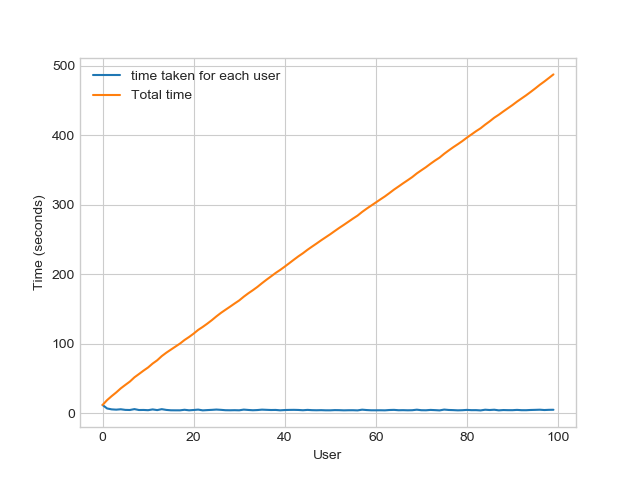

----------------------------------------------------------------------------------------------------
Time taken : 0:08:22.567970


In [73]:
start = datetime.now()
u_u_sim_sparse, _ = compute_user_similarity(train_sparse_submit_matrix, compute_for_few=True, top = 100,
                                                     verbose=True)
print("-"*100)
print("Time taken :",datetime.now()-start)

In [38]:
# First Let's load the movie details into soe dataframe..
# movie details are in 'netflix/movie_titles.csv'

movie_titles = pd.read_csv("movie_titles.csv", sep=',', header = None,
                           names=['movie_id', 'year_of_release', 'title'], verbose=True,
                      index_col = 'movie_id', encoding = "ISO-8859-1")

movie_titles.head

Tokenization took: 22.16 ms
Type conversion took: 300.74 ms
Parser memory cleanup took: 0.00 ms


<bound method NDFrame.head of           year_of_release                                              title
movie_id                                                                    
1                  2003.0                                    Dinosaur Planet
2                  2004.0                         Isle of Man TT 2004 Review
3                  1997.0                                          Character
4                  1994.0                       Paula Abdul's Get Up & Dance
5                  2004.0                           The Rise and Fall of ECW
6                  1997.0                                               Sick
7                  1992.0                                              8 Man
8                  2004.0                         What the #$*! Do We Know!?
9                  1991.0                           Class of Nuke 'Em High 2
10                 2001.0                                            Fighter
11                 1999.0                     

In [39]:
start = datetime.now()
if not os.path.isfile('m_m_sim_sparse.npz'):
    print("It seems you don't have that file. Computing movie_movie similarity...")
    start = datetime.now()
    m_m_sim_sparse = cosine_similarity(X=train_sparse_submit_matrix.T, dense_output=False)
    print("Done..")
    # store this sparse matrix in disk before using it. For future purposes.
    print("Saving it to disk without the need of re-computing it again.. ")
    sparse.save_npz("m_m_sim_sparse.npz", m_m_sim_sparse)
    print("Done..")
else:
    print("It is there, We will get it.")
    m_m_sim_sparse = sparse.load_npz("m_m_sim_sparse.npz")
    print("Done ...")

print("It's a ",m_m_sim_sparse.shape," dimensional matrix")

print(datetime.now() - start)

It is there, We will get it.
Done ...
It's a  (17771, 17771)  dimensional matrix
0:01:10.305343


In [40]:
m_m_sim_sparse.shape

(17771, 17771)

- Even though we have similarity measure of each movie, with all other movies, We generally don't care much about least similar movies.


- Most of the times, only top_xxx similar items matters. It may be 10 or 100.


- We take only those top similar movie ratings and store them  in a saperate dictionary.

In [5]:
movie_ids = np.unique(m_m_sim_sparse.nonzero()[1])

In [6]:
movie_ids

array([    1,     2,     3, ..., 17768, 17769, 17770])

In [7]:
start = datetime.now()
similar_movies = dict()
for movie in movie_ids:
    # get the top similar movies and store them in the dictionary
    sim_movies = m_m_sim_sparse[movie].toarray().ravel().argsort()[::-1][1:]
    similar_movies[movie] = sim_movies[:100]
print(datetime.now() - start)

# just testing similar movies for movie_15
similar_movies[15]

0:00:59.717110


array([ 8279,  8013, 16528,  5927, 13105, 12049,  4424, 10193, 17590,
        4549,  3755,   590, 14059, 15144, 15054,  9584,  9071,  6349,
       16402,  3973,  1720,  5370, 16309,  9376,  6116,  4706,  2818,
         778, 15331,  1416, 12979, 17139, 17710,  5452,  2534,   164,
       15188,  8323,  2450, 16331,  9566, 15301, 13213, 14308, 15984,
       10597,  6426,  5500,  7068,  7328,  5720,  9802,   376, 13013,
        8003, 10199,  3338, 15390,  9688, 16455, 11730,  4513,   598,
       12762,  2187,   509,  5865,  9166, 17115, 16334,  1942,  7282,
       17584,  4376,  8988,  8873,  5921,  2716, 14679, 11947, 11981,
        4649,   565, 12954, 10788, 10220, 10963,  9427,  1690,  5107,
        7859,  5969,  1510,  2429,   847,  7845,  6410, 13931,  9840,
        3706], dtype=int64)

In [15]:
mv_id = 1

print("\nMovie ----->",movie_titles.loc[mv_id].values[1])

print("\nIt has {} Ratings from users.".format(train_sparse_submit_matrix[:,mv_id].getnnz()))

print("\nWe have {} movies which are similarto this  and we will get only top most..".format(m_m_sim_sparse[:,mv_id].getnnz()))


Movie -----> Dinosaur Planet

It has 395 Ratings from users.

We have 17297 movies which are similarto this  and we will get only top most..


In [16]:
similarities = m_m_sim_sparse[mv_id].toarray().ravel()

similar_indices = similarities.argsort()[::-1][1:]

similarities[similar_indices]

sim_indices = similarities.argsort()[::-1][1:] # It will sort and reverse the array and ignore its similarity (ie.,1)
                                               # and return its indices(movie_ids)

<IPython.core.display.Javascript object>


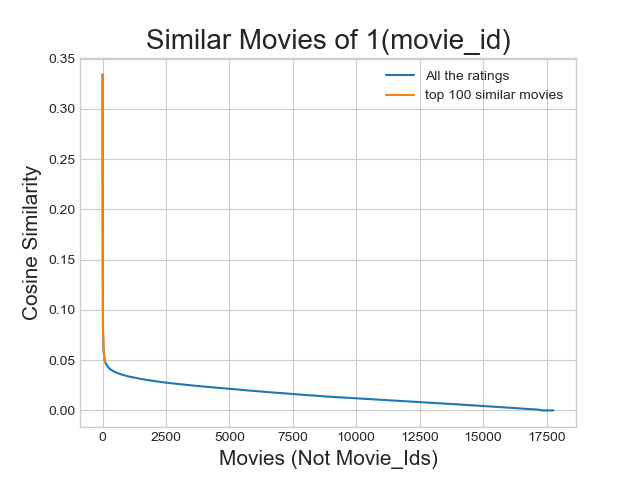

In [17]:
plt.plot(similarities[sim_indices], label='All the ratings')
plt.plot(similarities[sim_indices[:100]], label='top 100 similar movies')
plt.title("Similar Movies of {}(movie_id)".format(mv_id), fontsize=20)
plt.xlabel("Movies (Not Movie_Ids)", fontsize=15)
plt.ylabel("Cosine Similarity",fontsize=15)
plt.legend()
plt.show()

In [18]:
movie_titles.loc[sim_indices[:10]]

,year_of_release,title
movie_id,,
694,2000.0,When Dinosaurs Roamed America
5302,2003.0,Chased by Dinosaurs: Three Walking with Dinosa...
1084,2001.0,Walking with Prehistoric Beasts
13586,2001.0,Allosaurus: A Walking with Dinosaurs Special
1173,1999.0,Walking with Dinosaurs
4181,2003.0,Walking with Cavemen
8800,2003.0,Prehistoric America: A Journey Through the Ice...
10656,2003.0,Before We Ruled the Earth: Mastering the Beasts
15648,2002.0,National Geographic: Dinosaur Hunters: Secrets...


In [96]:
start = datetime.now()
path = "train_assignment_submit.npz"
if os.path.isfile(path):
    print("It is present in your pwd, getting it from disk....")
    # just get it from the disk instead of computing it
    sample_train_sparse_matrix = sparse.load_npz(path)
    print("DONE..")
else: 
    # get 300kk users and 15k movies from available data 
    sample_train_sparse_matrix = get_sample_sparse_matrix(train_sparse_submit_matrix, no_users = 15000, no_movies = 1000,
                                             path = path)

print(datetime.now() - start)

Original Matrix : (users, movies) -- (405041 17424)
Original Matrix : Ratings -- 80384405

Sampled Matrix : (users, movies) -- (15000 1000)
Sampled Matrix : Ratings -- 193810
Saving it into disk for furthur usage..
Done..

0:00:53.460698


In [97]:
start = datetime.now()

path = "test_assignment_submit.npz"
if os.path.isfile(path):
    print("It is present in your pwd, getting it from disk....")
    # just get it from the disk instead of computing it
    sample_test_sparse_matrix = sparse.load_npz(path)
    print("DONE..")
else:
    # get 5k users and 500 movies from available data 
    sample_test_sparse_matrix = get_sample_sparse_matrix(test_sparse_submit_matrix, no_users= 5000, no_movies=500,
                                                 path = "test_assignment.npz")
print(datetime.now() - start)

Original Matrix : (users, movies) -- (349312 17757)
Original Matrix : Ratings -- 20096102

Sampled Matrix : (users, movies) -- (5000 500)
Sampled Matrix : Ratings -- 7333
Saving it into disk for furthur usage..
Done..

0:00:10.820100


In [107]:
# get the global average of ratings in our train set.
global_average = sample_train_sparse_matrix.sum()/sample_train_sparse_matrix.count_nonzero()
sample_train_averages['global'] = global_average
global_average


3.575733966255611

In [103]:
sample_train_averages['movie'] =  get_average_ratings(sample_train_sparse_matrix, of_users=False)
print('\n AVerage rating of movie 15153 :',sample_train_averages['movie'][15153])


 AVerage rating of movie 15153 : 2.6184210526315788


In [105]:
sample_train_averages['user'] = get_average_ratings(sample_train_sparse_matrix, of_users=True)
print('\nAverage rating of user 1515220 :',sample_train_averages['user'][1515220])


Average rating of user 1515220 : 3.9655172413793105


In [100]:
sample_train_averages = dict()

In [101]:
# get users, movies and ratings from our samples train sparse matrix
sample_train_users, sample_train_movies, sample_train_ratings = sparse.find(sample_train_sparse_matrix)

<h1> Featurizing data for regression problem </h1>

In [108]:
############################################################
# It took me almost 24 hours to prepare this train dataset.#
############################################################
start = datetime.now()
if os.path.isfile('sampled_train_assignment_submit.csv'):
    print("File already exists you don't have to prepare again..." )
else:
    print('preparing {} tuples for the dataset..\n'.format(len(sample_train_ratings)))
    with open('sampled_train_assignment.csv', mode='w') as reg_data_file:
        count = 0
        for (user, movie, rating)  in zip(sample_train_users, sample_train_movies, sample_train_ratings):
            st = datetime.now()
        #     print(user, movie)    
            #--------------------- Ratings of "movie" by similar users of "user" ---------------------
            # compute the similar Users of the "user"        
            user_sim = cosine_similarity(sample_train_sparse_matrix[user], sample_train_sparse_matrix).ravel()
            top_sim_users = user_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
            # get the ratings of most similar users for this movie
            top_ratings = sample_train_sparse_matrix[top_sim_users, movie].toarray().ravel()
            # we will make it's length "5" by adding movie averages to .
            top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_users_ratings.extend([sample_train_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))
        #     print(top_sim_users_ratings, end=" ")    


            #--------------------- Ratings by "user"  to similar movies of "movie" ---------------------
            # compute the similar movies of the "movie"        
            movie_sim = cosine_similarity(sample_train_sparse_matrix[:,movie].T, sample_train_sparse_matrix.T).ravel()
            top_sim_movies = movie_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
            # get the ratings of most similar movie rated by this user..
            top_ratings = sample_train_sparse_matrix[user, top_sim_movies].toarray().ravel()
            # we will make it's length "5" by adding user averages to.
            top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_movies_ratings.extend([sample_train_averages['user'][user]]*(5-len(top_sim_movies_ratings))) 
        #     print(top_sim_movies_ratings, end=" : -- ")

            #-----------------prepare the row to be stores in a file-----------------#
            row = list()
            row.append(user)
            row.append(movie)
            # Now add the other features to this data...
            row.append(sample_train_averages['global']) # first feature
            # next 5 features are similar_users "movie" ratings
            row.extend(top_sim_users_ratings)
            # next 5 features are "user" ratings for similar_movies
            row.extend(top_sim_movies_ratings)
            # Avg_user rating
            row.append(sample_train_averages['user'][user])
            # Avg_movie rating
            row.append(sample_train_averages['movie'][movie])

            # finalley, The actual Rating of this user-movie pair...
            row.append(rating)
            count = count + 1

            # add rows to the file opened..
            reg_data_file.write(','.join(map(str, row)))
            reg_data_file.write('\n')        
            if (count)%10000 == 0:
                # print(','.join(map(str, row)))
                print("Done for {} rows----- {}".format(count, datetime.now() - start))


print(datetime.now() - start)

preparing 193810 tuples for the dataset..

Done for 10000 rows----- 1:05:34.595015
Done for 20000 rows----- 2:18:06.297981
Done for 30000 rows----- 3:45:50.941814
Done for 40000 rows----- 5:56:46.925565
Done for 50000 rows----- 7:04:06.915061
Done for 60000 rows----- 9:09:37.009246
Done for 70000 rows----- 10:21:22.472597
Done for 80000 rows----- 11:29:29.204902
Done for 90000 rows----- 12:43:10.980011
Done for 100000 rows----- 13:50:14.416112
Done for 110000 rows----- 14:58:55.826429
Done for 120000 rows----- 15:59:07.133846
Done for 130000 rows----- 16:58:16.725871
Done for 140000 rows----- 17:57:26.083572
Done for 150000 rows----- 18:56:34.613342
Done for 160000 rows----- 19:55:47.735823
Done for 170000 rows----- 20:54:54.922157
Done for 180000 rows----- 21:54:06.716761
Done for 190000 rows----- 22:58:58.035843
23:41:23.036076


In [110]:
# get users, movies and ratings from the Sampled Test 
sample_test_users, sample_test_movies, sample_test_ratings = sparse.find(sample_test_sparse_matrix)

In [112]:
start = datetime.now()

if os.path.isfile('sampled_test_assignment_submit.csv'):
    print("It is already created...")
else:

    print('preparing {} tuples for the dataset..\n'.format(len(sample_test_ratings)))
    with open('sampled_test_assignment.csv', mode='w') as reg_data_file:
        count = 0 
        for (user, movie, rating)  in zip(sample_test_users, sample_test_movies, sample_test_ratings):
            st = datetime.now()

        #--------------------- Ratings of "movie" by similar users of "user" ---------------------
            #print(user, movie)
            try:
                # compute the similar Users of the "user"        
                user_sim = cosine_similarity(sample_train_sparse_matrix[user], sample_train_sparse_matrix).ravel()
                top_sim_users = user_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
                # get the ratings of most similar users for this movie
                top_ratings = sample_train_sparse_matrix[top_sim_users, movie].toarray().ravel()
                # we will make it's length "5" by adding movie averages to .
                top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_users_ratings.extend([sample_train_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))
                # print(top_sim_users_ratings, end="--")

            except (IndexError, KeyError):
                # It is a new User or new Movie or there are no ratings for given user for top similar movies...
                ########## Cold STart Problem ##########
                top_sim_users_ratings.extend([sample_train_averages['global']]*(5 - len(top_sim_users_ratings)))
                #print(top_sim_users_ratings)
            except:
                print(user, movie)
                # we just want KeyErrors to be resolved. Not every Exception...
                raise



            #--------------------- Ratings by "user"  to similar movies of "movie" ---------------------
            try:
                # compute the similar movies of the "movie"        
                movie_sim = cosine_similarity(sample_train_sparse_matrix[:,movie].T, sample_train_sparse_matrix.T).ravel()
                top_sim_movies = movie_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
                # get the ratings of most similar movie rated by this user..
                top_ratings = sample_train_sparse_matrix[user, top_sim_movies].toarray().ravel()
                # we will make it's length "5" by adding user averages to.
                top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_movies_ratings.extend([sample_train_averages['user'][user]]*(5-len(top_sim_movies_ratings))) 
                #print(top_sim_movies_ratings)
            except (IndexError, KeyError):
                #print(top_sim_movies_ratings, end=" : -- ")
                top_sim_movies_ratings.extend([sample_train_averages['global']]*(5-len(top_sim_movies_ratings)))
                #print(top_sim_movies_ratings)
            except :
                raise

            #-----------------prepare the row to be stores in a file-----------------#
            row = list()
            # add usser and movie name first
            row.append(user)
            row.append(movie)
            row.append(sample_train_averages['global']) # first feature
            #print(row)
            # next 5 features are similar_users "movie" ratings
            row.extend(top_sim_users_ratings)
            #print(row)
            # next 5 features are "user" ratings for similar_movies
            row.extend(top_sim_movies_ratings)
            #print(row)
            # Avg_user rating
            try:
                row.append(sample_train_averages['user'][user])
            except KeyError:
                row.append(sample_train_averages['global'])
            except:
                raise
            #print(row)
            # Avg_movie rating
            try:
                row.append(sample_train_averages['movie'][movie])
            except KeyError:
                row.append(sample_train_averages['global'])
            except:
                raise
            #print(row)
            # finalley, The actual Rating of this user-movie pair...
            row.append(rating)
            #print(row)
            count = count + 1

            # add rows to the file opened..
            reg_data_file.write(','.join(map(str, row)))
            #print(','.join(map(str, row)))
            reg_data_file.write('\n')        
            if (count)%1000 == 0:
                #print(','.join(map(str, row)))
                print("Done for {} rows----- {}".format(count, datetime.now() - start))
    print("",datetime.now() - start)  

preparing 7333 tuples for the dataset..

Done for 1000 rows----- 0:07:05.643806
Done for 2000 rows----- 0:14:11.634710
Done for 3000 rows----- 0:21:22.592097
Done for 4000 rows----- 0:28:37.582972
Done for 5000 rows----- 0:34:51.998278
Done for 6000 rows----- 0:40:53.300074
Done for 7000 rows----- 0:47:48.852193
 0:50:06.747768
